# Customer Churn Prediction

In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install joblib


In [27]:
!pip install xgboost lightgbm
!pip install shap


   ---------------------------------------- 0.0/552.3 kB ? eta -:--:--
   ------------------ --------------------- 262.1/552.3 kB ? eta -:--:--
   ------------------------------------- -- 524.3/552.3 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 552.3/552.3 kB 1.2 MB/s  0:00:00
   ---------------------------------------- 0.0/39.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.1 MB ? eta -:--:--
    --------------------------------------- 0.5/39.1 MB 1.3 MB/s eta 0:00:30
    --------------------------------------- 0.8/39.1 MB 1.3 MB/s eta 0:00:30
   - -------------------------------------- 1.0/39.1 MB 1.3 MB/s eta 0:00:30
   - -------------------------------------- 1.3/39.1 MB 1.3 MB/s eta 0:00:30
   - -------------------------------------- 1.6/39.1 MB 1.3 MB/s eta 0:00:30
   - -------------------------------------- 1.8/39.1 MB 1.3 MB/s eta 0:00:29
   -- ------------------------------------- 2.1/39.1 MB 1.3 MB/s eta 0:00:29
   -- --------------

In [28]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


# Metrics & utilities
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import joblib
import warnings
import shap

warnings.filterwarnings("ignore")

# Display settings
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.05)
pd.set_option('display.max_columns', 200)

# load the dataset

In [4]:
# Load dataset 
df = pd.read_csv("customer_data.csv")
print("Shape:", df.shape)
df.head()

Shape: (10000, 12)


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# initial inspection

In [5]:
# Info & Summary
display(df.info())
display(df.describe(include='all'). T)

# Missing values
print("\nMissing values per column:")
print(df.isnull().sum)

# Target distribution
print("\nChurn value counts:")
print(df['churn'].value_counts(normalize=False))
print("\nChurn proportion:")
print(df['churn'].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customer_id,10000.0,NaN,NaN,NaN,15690940.5694,71936.186123,15565701.0,15628528.25,15690738.0,15753233.75,15815690.0
credit_score,10000.0,NaN,NaN,NaN,650.5288,96.653299,350.0,584.0,652.0,718.0,850.0
country,10000,3,France,5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,10000,2,Male,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,10000.0,NaN,NaN,NaN,38.9218,10.487806,18.0,32.0,37.0,44.0,92.0
tenure,10000.0,NaN,NaN,NaN,5.0128,2.892174,0.0,3.0,5.0,7.0,10.0
balance,10000.0,NaN,NaN,NaN,76485.889288,62397.405202,0.0,0.0,97198.54,127644.24,250898.09
products_number,10000.0,NaN,NaN,NaN,1.5302,0.581654,1.0,1.0,1.0,2.0,4.0
credit_card,10000.0,NaN,NaN,NaN,0.7055,0.45584,0.0,0.0,1.0,1.0,1.0
active_member,10000.0,NaN,NaN,NaN,0.5151,0.499797,0.0,0.0,1.0,1.0,1.0



Missing values per column:
<bound method DataFrame.sum of       customer_id  credit_score  country  gender    age  tenure  balance  \
0           False         False    False   False  False   False    False   
1           False         False    False   False  False   False    False   
2           False         False    False   False  False   False    False   
3           False         False    False   False  False   False    False   
4           False         False    False   False  False   False    False   
...           ...           ...      ...     ...    ...     ...      ...   
9995        False         False    False   False  False   False    False   
9996        False         False    False   False  False   False    False   
9997        False         False    False   False  False   False    False   
9998        False         False    False   False  False   False    False   
9999        False         False    False   False  False   False    False   

      products_number  credi

# Step 4. Exploratory Data Analysis (visualizations)

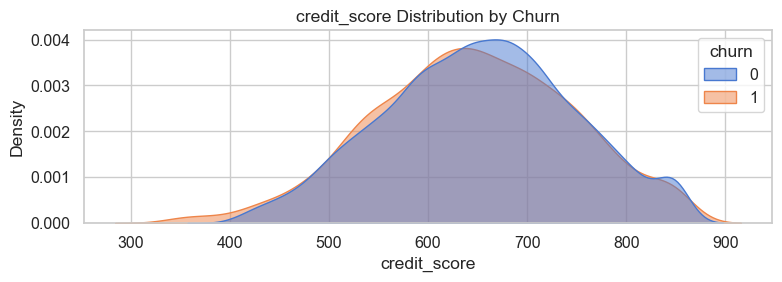

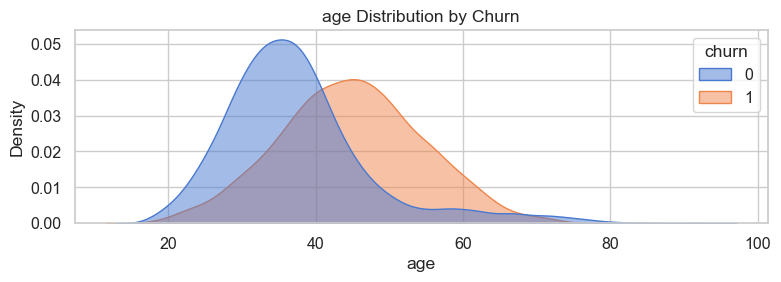

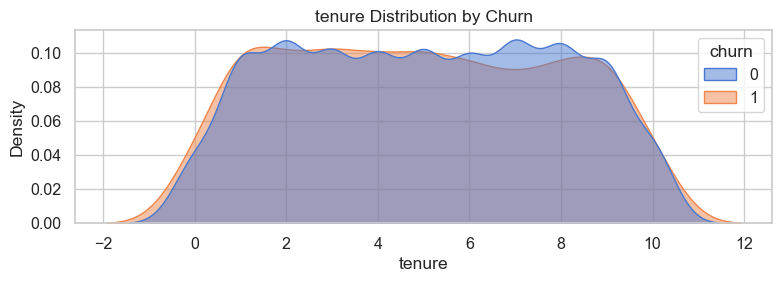

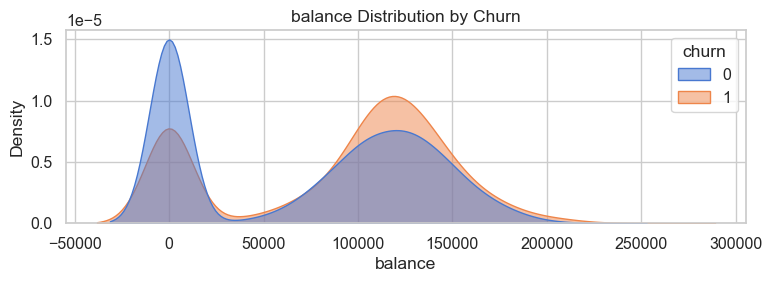

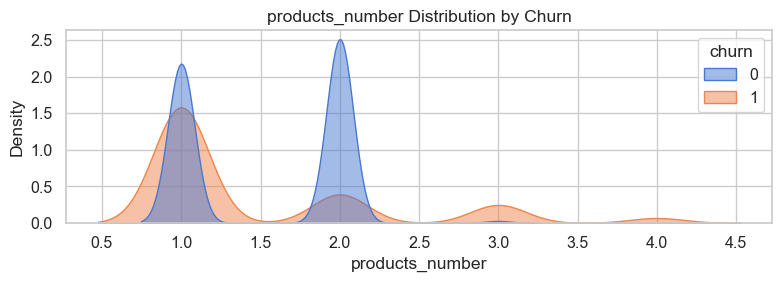

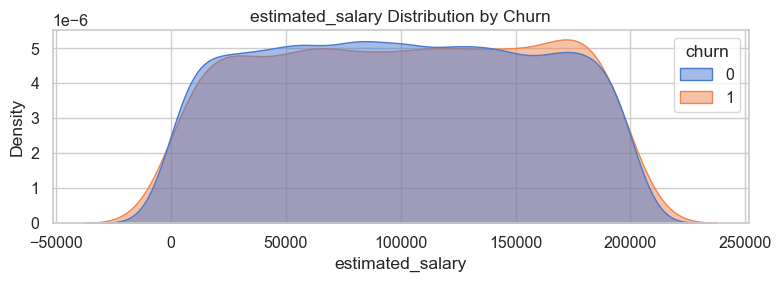

In [6]:
num_cols = ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'estimated_salary']

# --- Distribution plots
for col in num_cols:
    plt.figure(figsize=(8,3))
    sns.kdeplot(data=df, x=col, hue='churn', fill=True, common_norm=False, alpha=0.5)
    plt.title(f'{col} Distribution by Churn')
    plt.tight_layout()
    plt.show()

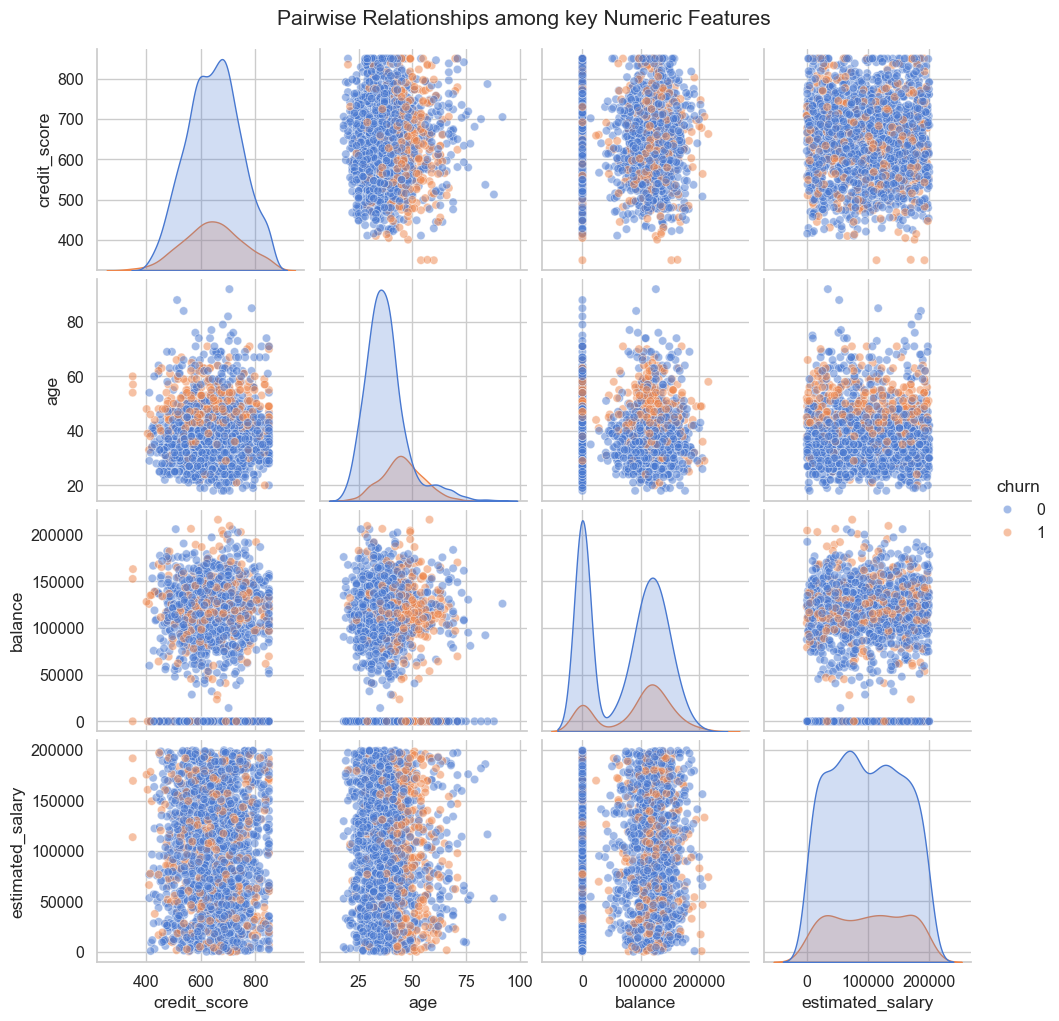

In [7]:
# --- Pairplot (sampled for speed)
sns.pairplot(df.sample(frac=0.2, random_state=42),
             vars=['credit_score', 'age', 'balance', 'estimated_salary'], 
            hue='churn', diag_kind='kde', plot_kws={'alpha':0.5})
plt.suptitle('Pairwise Relationships among key Numeric Features', y=1.02)
plt.show()

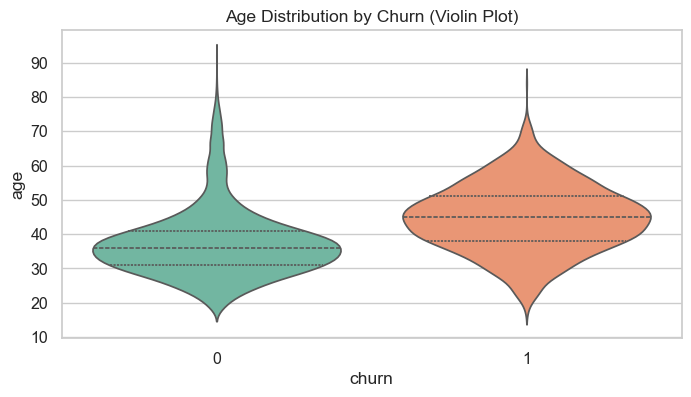

In [8]:
# --- Violin plot for Age
plt.figure(figsize=(8,4))
sns.violinplot(data=df, x='churn', y='age', inner='quart', palette='Set2')
plt.title('Age Distribution by Churn (Violin Plot)')
plt.show()

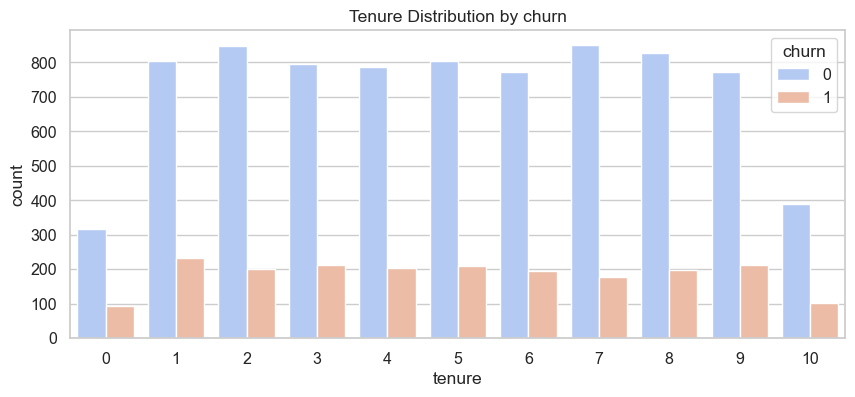

In [9]:
# --- Trnure distribution
plt.figure(figsize=(10,4))
sns.countplot(data=df, x='tenure', hue='churn', palette='coolwarm')
plt.title('Tenure Distribution by churn')
plt.show()

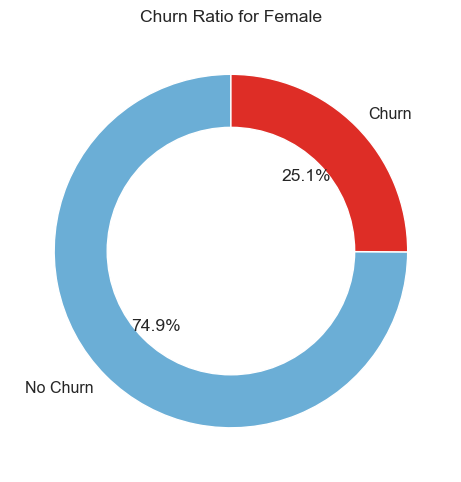

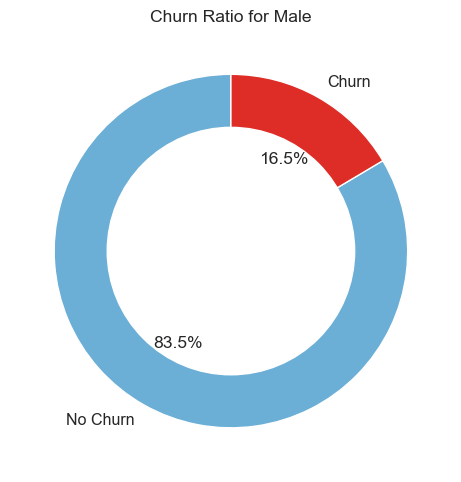

In [10]:
# --- Gender vs Churn Donut Chart
gender_counts = df.groupby('gender')['churn'].value_counts(normalize=True).unstack().fillna(0)
for gender in gender_counts.index:
    plt.figure(figsize=(5,5))
    plt.pie(gender_counts.loc[gender], labels=['No Churn', 'Churn'],
            autopct='%1.1f%%', startangle=90, colors=['#6baed6', '#de2d26'])
    center = plt.Circle((0,0),0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(center)
    plt.title(f'Churn Ratio for {gender}')
    plt.tight_layout()
    plt.show()

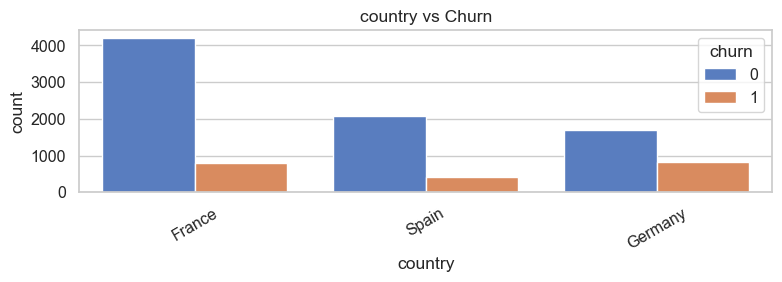

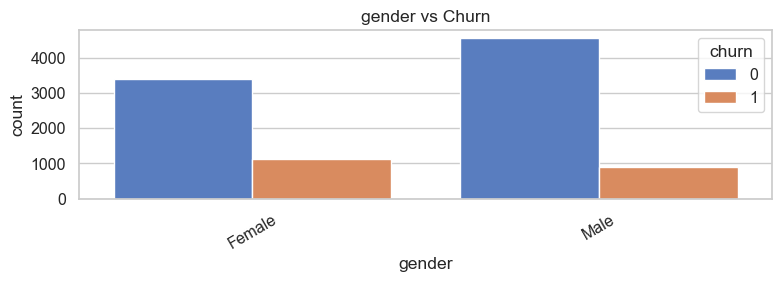

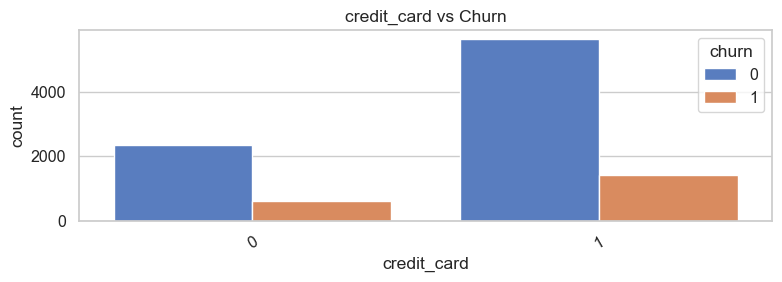

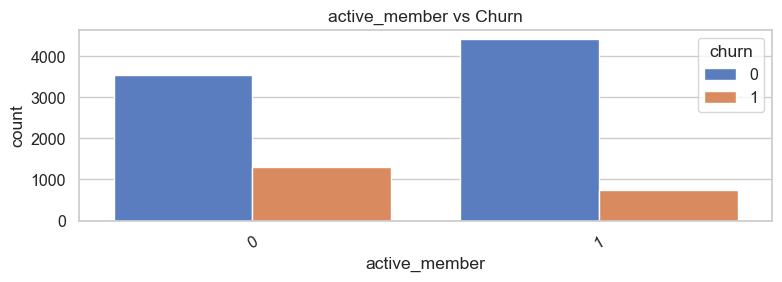

In [11]:
# --- Categorical features
cat_cols = ['country', 'gender', 'credit_card', 'active_member']
for c in cat_cols:
    plt.figure(figsize=(8,3))
    sns.countplot(data=df, x=c, hue='churn')
    plt.title(f'{c} vs Churn')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

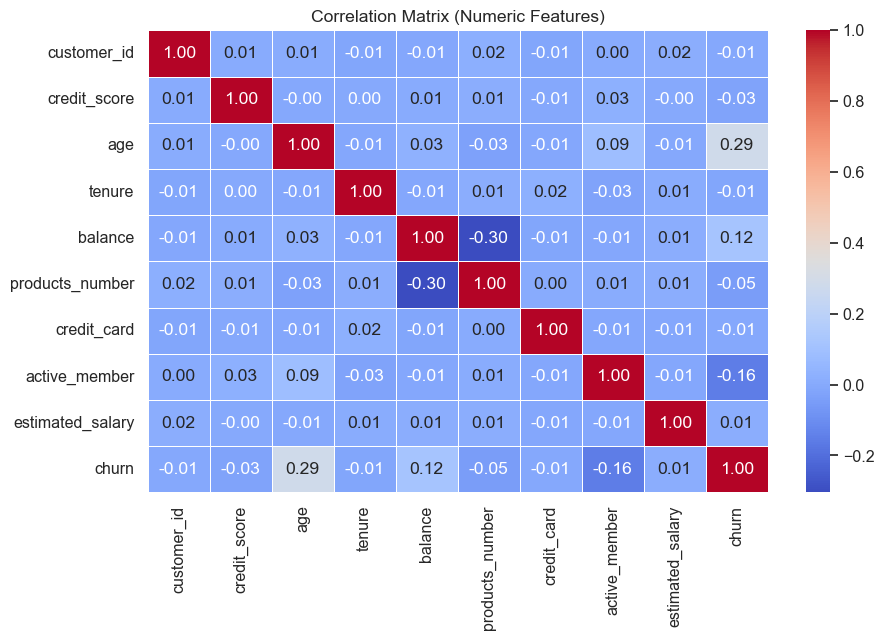

In [12]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix
corr = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix (Numeric Features)')
plt.show()


In [13]:
# --- Numeric Corellation heatmap
numeric_data = df[num_cols]  # use the numeric columns from your feature-engineered dataframe
corr = numeric_data.corr()
corr.style.background_gradient(cmap='coolwarm')

,credit_score,age,tenure,balance,products_number,estimated_salary
credit_score,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.001384
age,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.007201
tenure,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.007784
balance,0.006268,0.028308,-0.012254,1.000000,-0.304180,0.012797
products_number,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.014204
estimated_salary,-0.001384,-0.007201,0.007784,0.012797,0.014204,1.000000


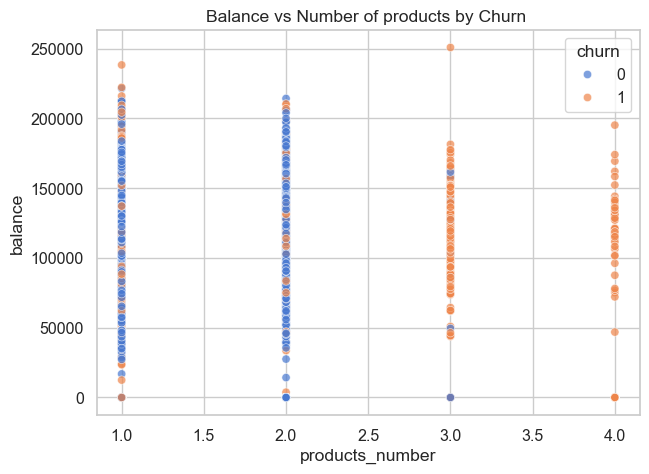

In [14]:
# --- Balance vs Products scatter
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x='products_number', y='balance', hue='churn', alpha=0.7)
plt.title('Balance vs Number of products by Churn ')
plt.show()

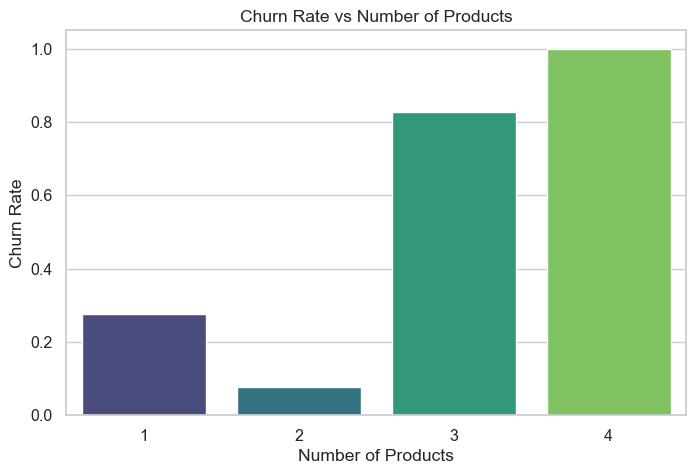

In [15]:
# --- Aggregate churn rate per number of products
churn_rate = df.groupby('products_number')['churn'].mean().reset_index()

# Plot churn rate
plt.figure(figsize=(8,5))
sns.barplot(data=churn_rate, x='products_number', y='churn', palette='viridis')
plt.xlabel('Number of Products')
plt.ylabel('Churn Rate')
plt.title('Churn Rate vs Number of Products')
plt.show()


# Step 5. Feature Engineering

In [16]:
# Feature engineering examples
df_fe = df.copy()

# Balance per product
df_fe['balance_per_product'] = df_fe['balance'] / (df_fe['products_number'].replace(0, np.nan))
df_fe['balance_per_product'].fillna(0, inplace=True)

# Salary to balance ratio
df_fe['salary_balance_ratio'] = df_fe['estimated_salary'] / (df_fe['balance'].replace(0, np.nan))
df_fe['salary_balance_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_fe['salary_balance_ratio'].fillna(df_fe['salary_balance_ratio'].median(), inplace=True)

# Age group
bins = [0,25,35,45,55,65,100]
labels = ['<25','25-34','35-44','45-54','55-64','65+']
df_fe['age_group'] = pd.cut(df_fe['age'], bins=bins, labels=labels)

# Tenure bucket
df_fe['tenure_bucket'] = pd.cut(df_fe['tenure'], bins=[-1,0,2,5,10,100], labels=['0','1-2','3-5','6-10','10+'])

# Flag high balance
df_fe['high_balance'] = (df_fe['balance'] > df_fe['balance'].quantile(0.75)).astype(int)

# Quick checks
df_fe[['balance_per_product','salary_balance_ratio','age','age_group','tenure','tenure_bucket','high_balance']].head()

,balance_per_product,salary_balance_ratio,age,age_group,tenure,tenure_bucket,high_balance
0,0.000000,0.839258,42,35-44,2,1-2,0
1,83807.860000,1.342864,41,35-44,1,1-2,0
2,53220.266667,0.713585,42,35-44,8,6-10,1
3,0.000000,0.839258,39,35-44,1,1-2,0
4,125510.820000,0.630098,43,35-44,2,1-2,0


# Step 6. Preprocessing - encoding & scaling

In [17]:
# Define features and target
target = 'churn'
drop_cols = ['customer_id']
features = [c for c in df_fe.columns if c not in [target] + drop_cols]

numeric_features = ['credit_score','age','tenure','balance','products_number','estimated_salary',
                    'balance_per_product','salary_balance_ratio']
categorical_features = ['country','gender','credit_card','active_member','age_group','tenure_bucket','high_balance']

df_fe[categorical_features] = df_fe[categorical_features].astype('object')

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

print('Numeric features:', numeric_features)
print('Categorical features:', categorical_features)

Numeric features: ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'estimated_salary', 'balance_per_product', 'salary_balance_ratio']
Categorical features: ['country', 'gender', 'credit_card', 'active_member', 'age_group', 'tenure_bucket', 'high_balance']


# Step 7. Train Test split

In [18]:
X = df_fe[features]
y = df_fe[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)
print('Train churn proportion:', y_train.mean(), 'Test churn proportion:', y_test.mean())

Train shape: (8000, 15) Test shape: (2000, 15)
Train churn proportion: 0.20375 Test churn proportion: 0.2035


# Step 8. Train Multiple models with a pipeline and compare using cross-validation

In [20]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=500),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=200, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=200, random_state=42),
    'SVC': SVC(probability=True, random_state=42),

    
    'XGBoost': XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ),

    'LightGBM': LGBMClassifier(
        n_estimators=200,
        learning_rate=0.1,
        random_state=42
    )
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    scores = cross_val_score(
        pipe,
        X_train,
        y_train,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1
    )
    
    results[name] = scores
    print(f"{name} AUC: Mean={scores.mean():.4f} Std={scores.std():.4f}")


LogisticRegression AUC: Mean=0.7877 Std=0.0244
RandomForest AUC: Mean=0.8486 Std=0.0130
GradientBoosting AUC: Mean=0.8628 Std=0.0097
AdaBoost AUC: Mean=0.8462 Std=0.0133
SVC AUC: Mean=0.8351 Std=0.0104
XGBoost AUC: Mean=0.8578 Std=0.0128
LightGBM AUC: Mean=0.8519 Std=0.0140


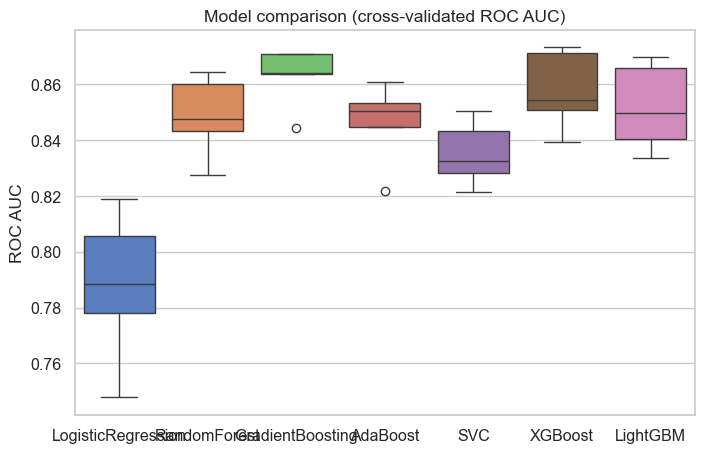

In [21]:
# Boxplot of CV AUC scores
plt.figure(figsize=(8,5))
sns.boxplot(data=[results[m] for m in list(results.keys())])
plt.xticks(ticks=range(len(results)), labels=list(results.keys()))
plt.ylabel('ROC AUC')
plt.title('Model comparison (cross-validated ROC AUC)')
plt.show()

# Step 9. Fit best model on full train set and evaluate on test set

In [22]:
# Choose best model (automatic pick by mean AUC)
best_name = max(results.keys(), key=lambda k: results[k].mean())
best_name, results[best_name].mean()

('GradientBoosting', np.float64(0.8627777349731776))

Test Accuracy: 0.8680
Test Precision: 0.7804
Test Recall: 0.4889
Test F1-score: 0.6012
Test ROC AUC: 0.8692

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.78      0.49      0.60       407

    accuracy                           0.87      2000
   macro avg       0.83      0.73      0.76      2000
weighted avg       0.86      0.87      0.86      2000



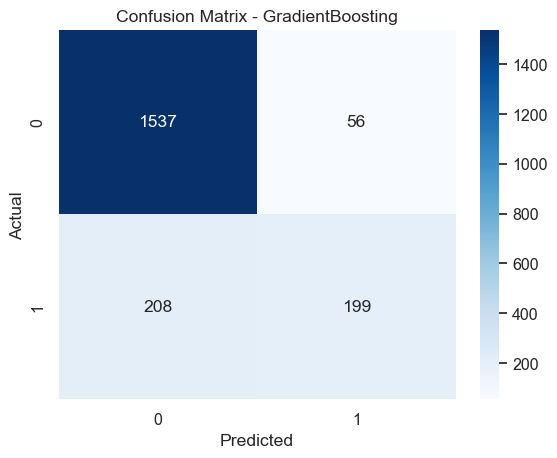

In [23]:
best_model = models[best_name]
best_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', best_model)])
best_pipeline.fit(X_train, y_train)

# Predictions
y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:,1]

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall: {rec:.4f}")
print(f"Test F1-score: {f1:.4f}")
print(f"Test ROC AUC: {roc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_name}')
plt.show()

# Step 10. Feature importance 

age                     0.327665
products_number         0.266459
balance_per_product     0.063396
balance                 0.056953
active_member_0         0.052653
country_Germany         0.050689
active_member_1         0.047992
salary_balance_ratio    0.029992
estimated_salary        0.025547
credit_score            0.022685
age_group_45-54         0.020634
age_group_55-64         0.007968
gender_Female           0.006850
gender_Male             0.006532
tenure                  0.005683
country_France          0.003164
tenure_bucket_3-5       0.001564
age_group_35-44         0.001415
credit_card_1           0.000697
country_Spain           0.000577
dtype: float64

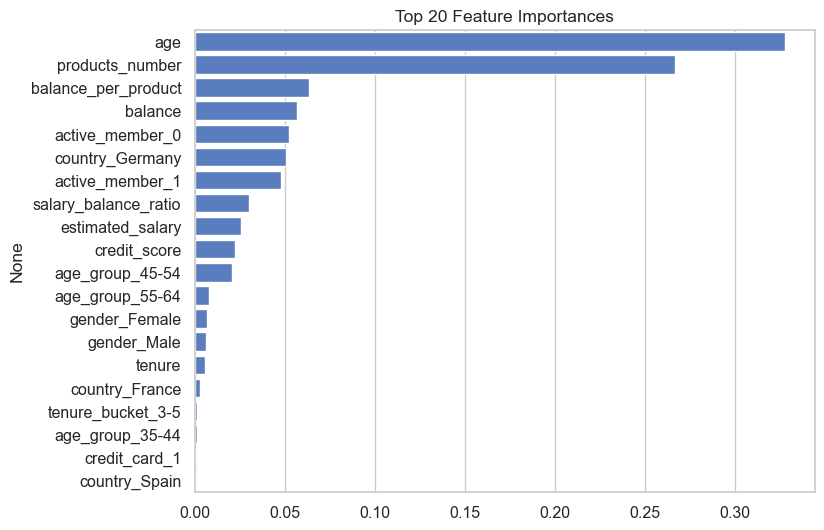

In [24]:
if hasattr(best_pipeline.named_steps['classifier'], 'feature_importances_'):
    num_feats = numeric_features
    cat_feats = list(best_pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features))
    feature_names = num_feats + cat_feats
    importances = best_pipeline.named_steps['classifier'].feature_importances_
    fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:20]
    display(fi)
    plt.figure(figsize=(8,6))
    sns.barplot(x=fi.values, y=fi.index)
    plt.title('Top 20 Feature Importances')
    plt.show()
else:
    print('Selected model does not provide feature_importances_ attribute.')

# Step 11. Save the best pipeline and preprocessing artifacts

In [25]:
joblib.dump(best_pipeline, 'best_churn_pipeline.pkl')
print("Saved pipeline: best_churn_pipeline.pkl")

Saved pipeline: best_churn_pipeline.pkl


# Step 12. Example: Predict churn for a new customer

In [26]:
# --- New customer sample ---
sample = {
    'customer_id': 373292028,
    'credit_score': 650,
    'country': 'France',
    'gender': 'Male',
    'age': 40,
    'tenure': 3,
    'balance': 50000.0,
    'products_number': 2,
    'credit_card': 1,
    'active_member': 1,
    'estimated_salary': 60000.0
}

sample_df = pd.DataFrame([sample])

# --- Apply same feature engineering ---
sample_df['balance_per_product'] = sample_df['balance'] / (sample_df['products_number'].replace(0, np.nan))
sample_df['balance_per_product'].fillna(0, inplace=True)

sample_df['salary_balance_ratio'] = sample_df['estimated_salary'] / (sample_df['balance'].replace(0, np.nan))
sample_df['salary_balance_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
sample_df['salary_balance_ratio'].fillna(sample_df['salary_balance_ratio'].median(), inplace=True)

bins = [0,25,35,45,55,65,100]
labels = ['<25','25-34','35-44','45-54','55-64','65+']
sample_df['age_group'] = pd.cut(sample_df['age'], bins=bins, labels=labels)

sample_df['tenure_bucket'] = pd.cut(sample_df['tenure'], bins=[-1,0,2,5,10,100], labels=['0','1-2','3-5','6-10','10+'])
sample_df['high_balance'] = (sample_df['balance'] > 50000.0).astype(int)  # can use 75th percentile of training set


# --- Drop ID ---
sample_df = sample_df.drop(columns=['customer_id'])

# --- Predict ---
pred = best_pipeline.predict(sample_df)[0]
prob = best_pipeline.predict_proba(sample_df)[0,1]

print(f'Predicted churn: {pred}, probability of churn: {prob:.3f}')

Predicted churn: 0, probability of churn: 0.030


# STEP 13. Model Explainability (SHAP + LIME)

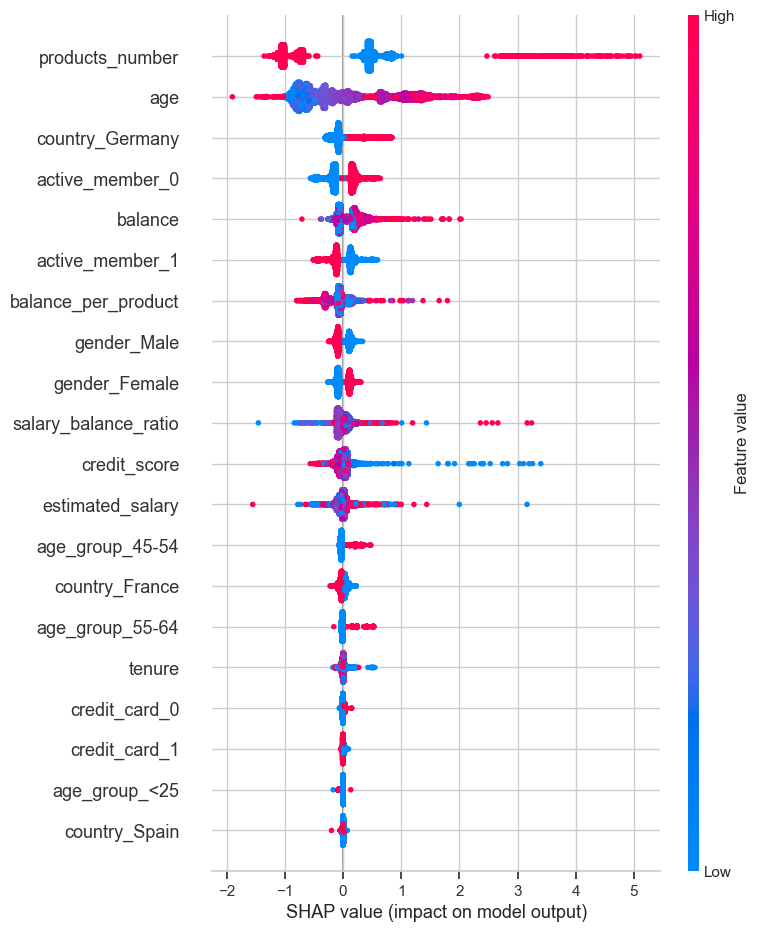

In [31]:
# Transform training data
X_train_transformed = best_pipeline.named_steps['preprocessor'].transform(X_train)

# Get feature names
num_feats = numeric_features
cat_feats = list(
    best_pipeline.named_steps['preprocessor']
    .transformers_[1][1]
    .named_steps['onehot']
    .get_feature_names_out(categorical_features)
)

feature_names = num_feats + cat_feats
#Create SHAP Explainer (Tree vs Non-Tree handled safely)

model = best_pipeline.named_steps['classifier']

if hasattr(model, "feature_importances_"):
    explainer = shap.TreeExplainer(model)
else:
    explainer = shap.Explainer(model, X_train_transformed)

shap_values = explainer(X_train_transformed)
#SHAP Summary Plot (GLOBAL EXPLANATION)

shap.summary_plot(
    shap_values,
    X_train_transformed,
    feature_names=feature_names,
    show=True
)


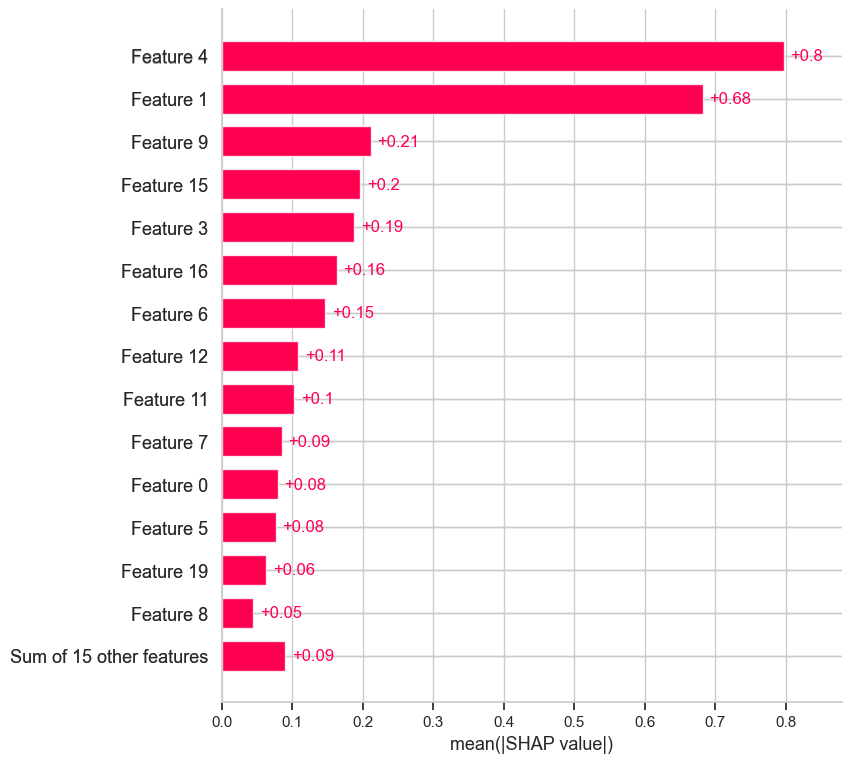

In [32]:
# SHAP Bar Plot (Feature Importance)
shap.plots.bar(shap_values, max_display=15)


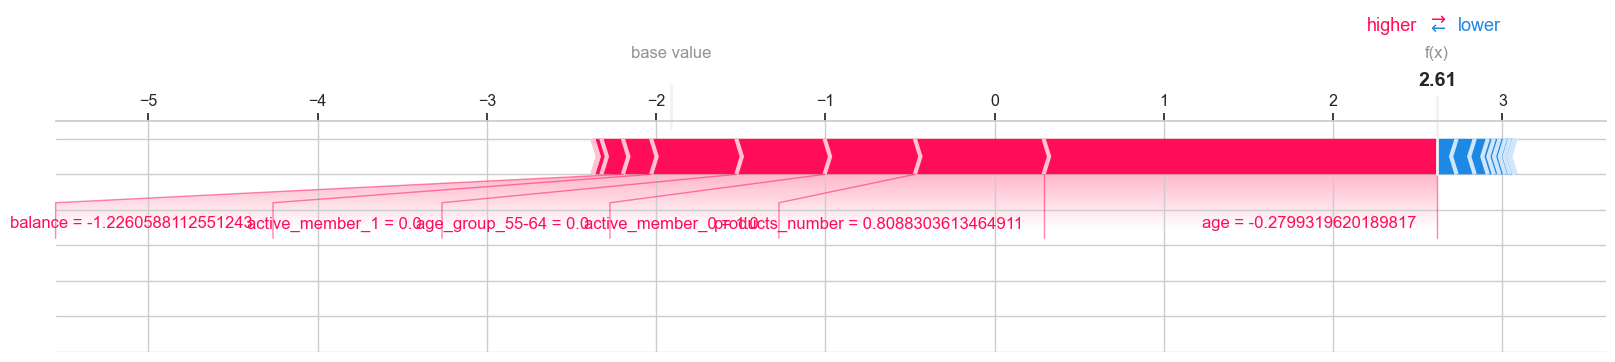

In [33]:
# SHAP Force Plot (LOCAL explanation for 1 customer)
# Explain first test customer
X_test_transformed = best_pipeline.named_steps['preprocessor'].transform(X_test)

shap.force_plot(
    explainer.expected_value,
    shap_values.values[0],
    X_test_transformed[0],
    feature_names=feature_names,
    matplotlib=True
)


# PART B: LIME Explainability (Instance-level)

In [34]:
! pip install lime


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.0 MB 1.4 MB/s eta 0:00:09
   -- ------------------------------------- 0.8/12.0 MB 1.3 MB/s eta 0:00:09
   --- ------------------------------------ 1.0/12.0 MB 1.3 MB/s eta 0:00:09
   ---- ----------------------------------- 1.3/12.0 MB 1.3 MB/s eta 0:00:09
   ----- ---------------------------------- 1.6/12.0 MB 1.3 MB/s eta 0:00:09
   ------ --------------------------------- 1.8/12.0 MB 1.3 MB/s eta 0:00:08
   ------ --------------------------------- 2.1/12.0 MB 1.3 MB/s eta

 97%|=================== | 7743/8000 [00:30<00:00]       

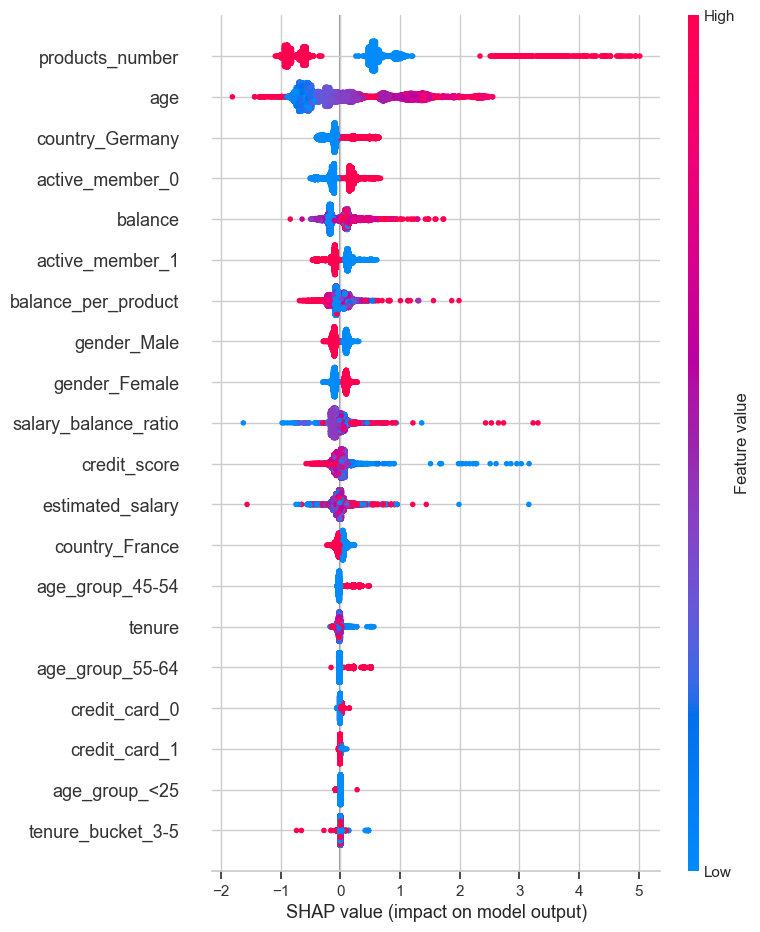

In [39]:
X_train_t = best_pipeline.named_steps['preprocessor'].transform(X_train)

num_feats = numeric_features
cat_feats = list(
    best_pipeline.named_steps['preprocessor']
    .transformers_[1][1]
    .named_steps['onehot']
    .get_feature_names_out(categorical_features)
)
feature_names = num_feats + cat_feats

explainer = shap.Explainer(best_pipeline.named_steps['classifier'], X_train_t)
shap_values = explainer(X_train_t)

shap.summary_plot(shap_values, X_train_t, feature_names=feature_names)


In [40]:
X_test_t = best_pipeline.named_steps['preprocessor'].transform(X_test)

lime_explainer = LimeTabularExplainer(
    X_train_t,
    feature_names=feature_names,
    class_names=['No Churn','Churn'],
    mode='classification'
)

exp = lime_explainer.explain_instance(
    X_test_t[0],
    best_pipeline.named_steps['classifier'].predict_proba,
    num_features=10
)

# SAFE OUTPUT
for f, w in exp.as_list():
    print(f"{f}: {w:.4f}")


-0.66 < age <= -0.18: -0.0774
active_member_1 <= 0.00: 0.0502
0.00 < active_member_0 <= 1.00: 0.0415
-0.91 < products_number <= 0.81: -0.0361
country_Germany <= 0.00: -0.0292
balance <= -1.23: -0.0273
0.00 < gender_Male <= 1.00: -0.0260
age_group_55-64 <= 0.00: -0.0226
tenure_bucket_0 <= 0.00: -0.0182
age_group_65+ <= 0.00: -0.0125


In [41]:
! pip install fastapi uvicorn pydantic prometheus-client


   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.5/2.0 MB 1.4 MB/s eta 0:00:02
   --------------- ------------------------ 0.8/2.0 MB 1.4 MB/s eta 0:00:01
   -------------------- ------------------- 1.0/2.0 MB 1.3 MB/s eta 0:00:01
   -------------------------- ------------- 1.3/2.0 MB 1.3 MB/s eta 0:00:01
   ------------------------------- -------- 1.6/2.0 MB 1.3 MB/s eta 0:00:01
   ------------------------------------ --- 1.8/2.0 MB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 2.0/2.0 MB 1.3 MB/s  0:00:01

   ---- ----------------------------------- 1/9 [pydantic-core]
   -------- ------------------------------- 2/9 [click]
   -------- ------------------------------- 2/9 [click]
   ---------------------- ----------------- 5/9 [uvicorn]
   ---------------------- ----------------- 5/9 [uvicorn]
   ---------------------- --------------